<a href="https://colab.research.google.com/github/bergerwill/ns/blob/main/ns_coupler_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Freight Train Coupler

Freight Train cars are joined by couplers. Couplers are mechanisms that join rail cars together to form a
train. We want to localize couplers to be able to diagnose issues with the couplers. Couplers are an important
component that can cause separation of trains if they are not healthy.

## Data

* Located under ./data
* 200 images: ./data/images
* 200 labels: ./data/labels
* 459 test images: ./data/test-images - images without labels that can be used for testing or any other purposes
you want

* Label format: https://opencv.github.io/cvat/docs/manual/advanced/formats/format-yolo/

## The Environment

### Google Colab

I chose Google Colab so I could have cheap access to GPU resources and it is pretty easy to share the solution as well.  In real world environment I would put this in a git repository.

### Python Packages installation

The requirements.txt file contains all the python packages needed in order to run this coupler model.  

It was generated via pip freeze > requirements.txt

But all you really need is pip install ultralytics as shown below.  I settled in on using Yolo8.  I will explain this later.



In [ ]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.7/592.7 kB 10.3 MB/s eta 0:00:00


### Mount Google Drive

Here we are mounting the google drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Specifying the root directory where all the coupler images and code resides.

In [ ]:
ROOT_DIR = '/content/gdrive/My Drive/Colab Notebooks/ns'

## Tasks

## Explore the dataset

First I will inspect the images to determine the image format and understand some basic things, like the shape, color.  Can I load the images, determine the color mode, are the images clear and visible.




#### ImageUtils - image_utils.py
I created a helper class to hide the details of opencv.  Please review if interested.

In [ ]:
import sys
sys.path.append(ROOT_DIR)
from image_utils import ImageUtils 

### Inspect Test Images

Next we will

* iterate over all the images in the "data/images"
* loading the images inspect their attributes, observing
  * did the image load and display properly ?
  * what is the image shape ?
  * what is the image format ? 
  * what is the color mode ? (RGB, BGR, Greyscale, etc). This helps me understand are the any color conversions i need t be are of.

Use the cell stop button to stop reviewing the image

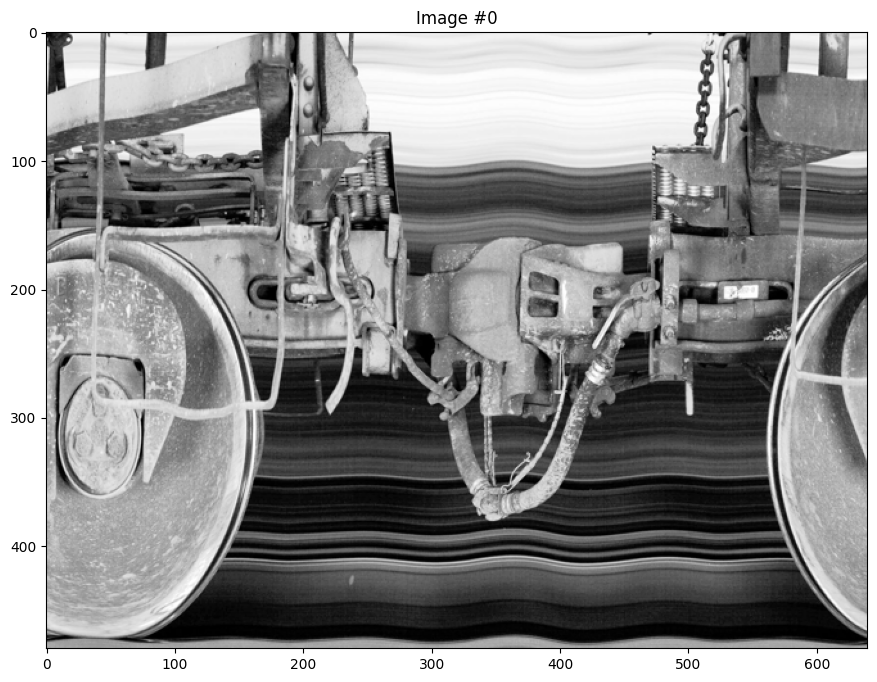

Image #0
Filename 2023-04-15-190215896_Test1Site_3744_1_19-20_KBSR0000076122-KBSR0000470070_ls_coupler_NULL-B_1-A_R-L_B-B_NULL-NULL.jpeg
Image format: None
Image size: (1668, 1024)
Image mode: RGB


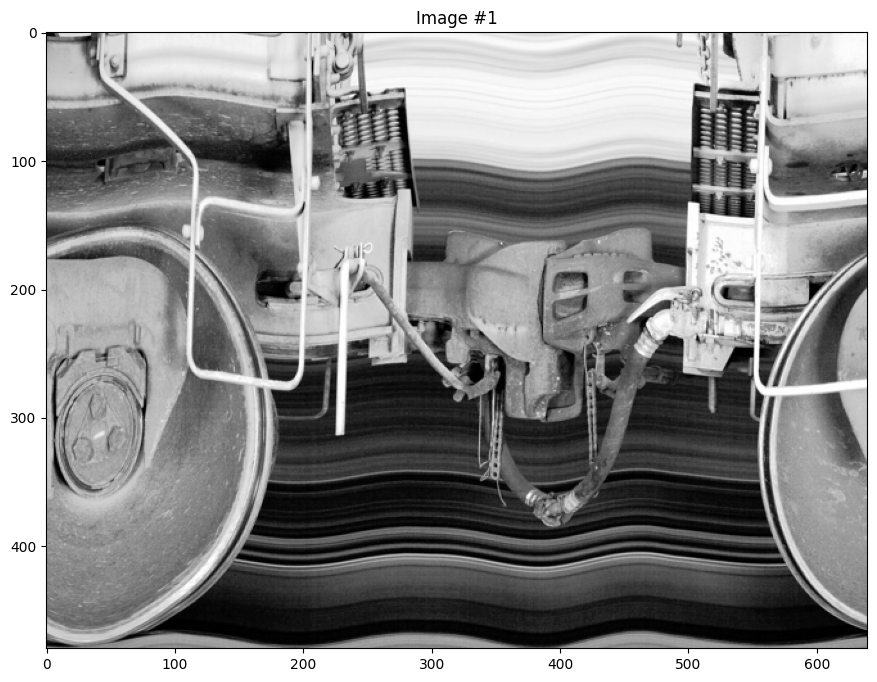

Image #1
Filename 2023-04-15-190316141_Test1Site_3744_1_53-54_ALHX0000004006-CITX0000775353_ls_coupler_NULL-NULL_1-A_R-L_B-B_NULL-NULL.jpeg
Image format: None
Image size: (1576, 1024)
Image mode: RGB


In [ ]:
   num_images = 2
   ImageUtils.display_all_images_folder(num_images, ROOT_DIR+"/data/images", 640,480)

### Observations

* These images are relatively large images meaning quite a bit larger than 640x480
* These image are in RGB format but display in gray scale
* These images vary in size
* These images vary in size (1572,1024), (1464,1024), (4270,1024).  Depending on the model selected, this may require resizing of the imaging before inferencing to meet the input requirements of a model.

### Validating the Labels

The labels that have been given are in yolo format, meaning values are normalized and drawn from the center point.  They follow the yolo standard where the labels are located in the data/labels folder and the filename maps to a coresponding filename image in the data/images folder.

Let's validate that the lables are properly identifying the couplers by drawing the bounding boxes on the images inspecting them.



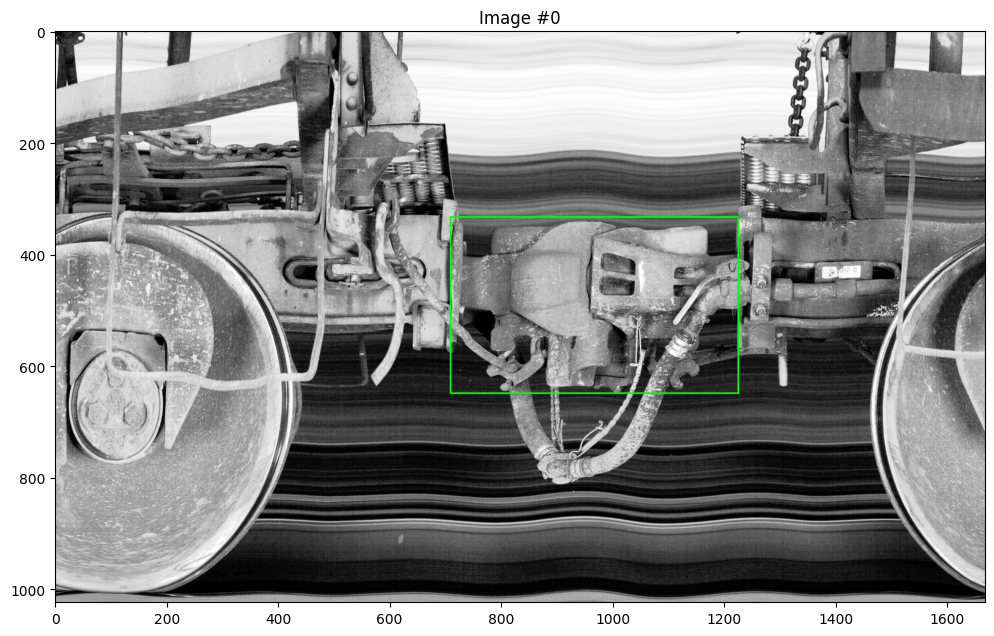

Image #0
Image /content/gdrive/My Drive/Colab Notebooks/ns/data//images/2023-04-15-190215896_Test1Site_3744_1_19-20_KBSR0000076122-KBSR0000470070_ls_coupler_NULL-B_1-A_R-L_B-B_NULL-NULL.jpeg
Image format: JPEG
Image size: (1668, 1024)
Image mode: RGB


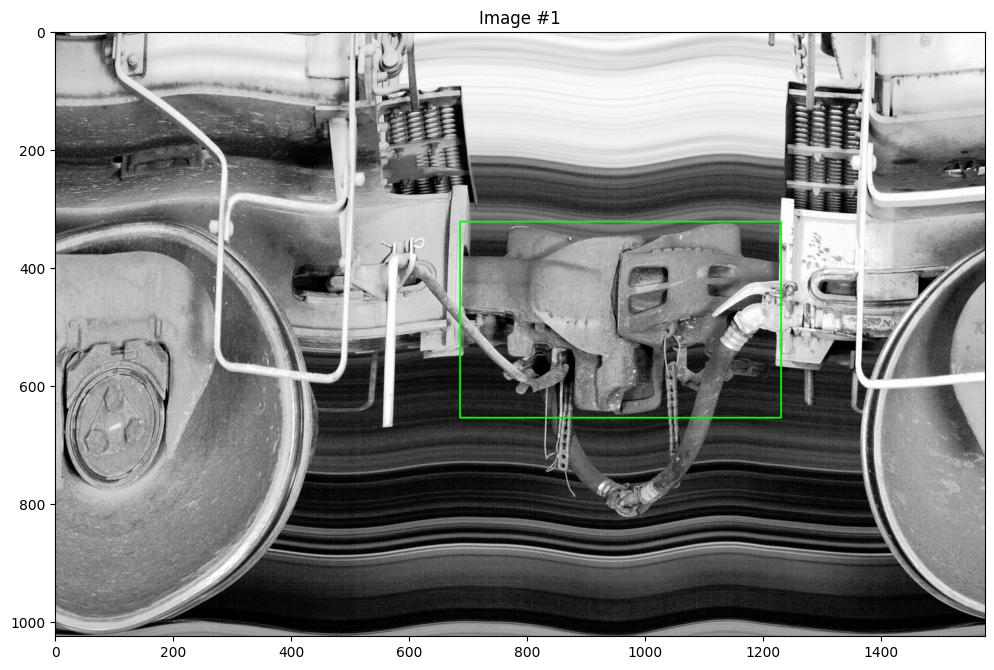

Image #1
Image /content/gdrive/My Drive/Colab Notebooks/ns/data//images/2023-04-15-190316141_Test1Site_3744_1_53-54_ALHX0000004006-CITX0000775353_ls_coupler_NULL-NULL_1-A_R-L_B-B_NULL-NULL.jpeg
Image format: JPEG
Image size: (1576, 1024)
Image mode: RGB


In [ ]:
  num_images = 2
  ImageUtils.display_all_labels_folder(num_images, ROOT_DIR+"/data/", 640,480)


### Model Selection

After revieing the problem statement and the dataset, I concluded that the single-stage object detector, YOLO (You Only Look Once) v8 model, would be the most suitable choice for our task. Here's how I arrived at this decision.

Fast R-CNN is indeed an efficient and precise object detector that is incorporated into the PyTorch framework. It excels at identifying objects in close proximity. However, it has certain noticeable drawbacks. Being a two-stage object detector, the first stage involves region proposal network, that generates a set of region proposals, that may contain objects,  while the second stage involves classification and bounding box regression. This results in a slower inference time. Moreover, our task predominantly involves identifying a single object the coupler, which negates the need for detecting multiple objects in the same vicinity.

The SSD (Single Shot MultiBox Detector) could also have been a plausible choice, being a single-stage object detector as well. It boasts impressive speed, but it can compromise on accuracy, which is a crucial factor for our task.

The YOLO V8 object detector, on the other hand, presents a compelling case. Implemented in PyTorch, it enjoys robust industry support, offers extraordinary speed, and maintains impressive accuracy. While real-time object detection in video streams is not a current requirement, selecting YOLO puts us in an advantageous position should such a need arise in the future. Also taking into account the time allocated for this task, employing YOLO v8 is a good choice. Its simplicity and user-friendly nature allow for a more efficient workflow, reducing the total time required to complete the exercise.

Therefore, considering the advantages and potential future applications, YOLO v8 emerged as the most fitting choice for this problem.




### Preparing for Train, Validate, and Test

This only gets executed once, to split the images into train, validate, test folders

In [48]:
# function to move files
def move_files(files, target_dir):
    for f in files:

        print("move")
        print(f". {os.path.join(data_dir+'/images', f)}")
        print("to")
        print(f". {os.path.join(target_dir+'images', f)}")
        
        file_name_with_ext, file_ext = os.path.splitext(os.path.basename(f))

        label_filename = file_name_with_ext + ".txt"

        shutil.move(os.path.join(data_dir+"/images", f), os.path.join(target_dir+"/images", f))
        shutil.move(os.path.join(data_dir+"/labels", label_filename), os.path.join(target_dir+"/labels", label_filename))


In [51]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split

# path to your dataset directory
data_dir = '/content/gdrive/MyDrive/Colab Notebooks/ns/data'

# create directories for train, val and test
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')


os.makedirs(train_dir+"/images", exist_ok=True)
os.makedirs(val_dir+"/images", exist_ok=True)
os.makedirs(test_dir+"/images", exist_ok=True)

os.makedirs(train_dir+"/labels", exist_ok=True)
os.makedirs(val_dir+"/labels", exist_ok=True)
os.makedirs(test_dir+"/labels", exist_ok=True)

# get a list of all image files in the direc
# get a list of all image files in the directory
image_files = [f for f in os.listdir(data_dir+"/images") if f.endswith('.jpeg') or f.endswith('.png')]

print(f"image_files cnt = {len(image_files)}")
if len(image_files) > 0:
    print(" Images have already be split into train, validate, test")

    # split the data by 80:20
    train_files, valtest_files = train_test_split(image_files, test_size=0.20, random_state=42)

    # split the 20% into validation and test sets
    val_files, test_files = train_test_split(valtest_files, test_size=0.50, random_state=42)

    print(f"train length:{len(train_files)}")
    print(f"val length:{len(val_files)}")
    print(f"test length:{len(test_files)}")


    # move the files
    move_files(train_files, train_dir)
    move_files(val_files, val_dir)
    move_files(test_files, test_dir)
else:
    print("data files have already been moved to train/val/test folders")


image_files cnt = 0
data files have already been moved to train/val/test folders


### Update yolo config yaml file

Next we update the Yolo configuration file (google_colab_config.file) so it knows where to find the train,validate, test data.



### Training the Coupler Model

We will initiate our process with a pre-existing YOLO V8 detection model that has been trained on the COCO dataset. There are five distinct pre-trained models available, each varying in size and performance.

The training process with YOLO is straightforward. Below are the steps involved:

* Instantiate a YOLO model object, specifying which YOLO 8 model to employ. Refer to our code snippet for details.

* Invoke the train method of the model, supplying it with a YAML configuration file. This file lays out the model's setup, including the locations of the training images and their respective labels. For more information, please refer to the google_colab_config.yaml file.

In this context, an epoch indicates a single cycle through the complete training dataset. Throughout each epoch, the model's weights get adjusted to reduce the value of the loss function.

Since we are running in Google Colab, we have cheap access to GPUs.

Below we will train this model over a 100 epochs on

Ultralytics YOLOv8.0.110 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)



In [52]:
import os

from ultralytics import YOLO


# Load the pre-trained model
model = YOLO("yolov8n.yaml")  

# Train the model
results = model.train(data=os.path.join(ROOT_DIR, "google_colab_config.yaml"), epochs=100)  # train the model



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

### Summarize Training Output

I am using a Tesla T4 GPU with 15102 MiB memory for training, Python 3.10.11, and PyTorch 2.0.1 for this task.

**Model Structure:**

The yolov8 model contains 225 layers with around 3 million parameters

**Training Details**

The training data consists of a 160 images with the training data located in '/content/gdrive/My Drive/Colab Notebooks/ns/data/train/labels'. There's also a validation set of 20 images located at '/content/gdrive/My Drive/Colab Notebooks/ns/data/val/labels'.
The training is set for 100 epochs with a batch size of 16 and an image size of 640.

** Optimizer **
SGD (Stochastic Gradient Descent) is the default optimizer for yolov8 and can be adjusted in the config.yaml file.  A potential optimization would be to use other Optimizers like Adam.  The goal of the optimizer is to adjust the parameters of the model in order to minimize the error or loss function. In other words, the optimizer's job is to navigate the model's parameters through the loss landscape in such a way that the model makes the most accurate predictions.

** Learning Rate **

The learning rate is set to 0.01.  The learning rate is a critical hyperparameter in the optimization process. It determines the size of the steps the optimizer takes while traversing the loss landscape.  

If the learning rate is to high the optimizer oscilates around the minimum without ever reaching it.  

If the learning rate is to low, the optimizer will take small steps which becomes an issue in resource contrained environments and never reach its minimum.

If the learning rate is just right:, the optimizer will converge to a satisfactory solution in a reasonable amount of time and that is what we are seeing in our results.  We still need to test it obviously.


**Loss Function**

The loss function for Yolo is a custom multi part loss function that is made of 3 components.

* Box Loss
* Class Loss
* Confidence Loss

**Box Loss** 
This loss measures how well the model is predicting the locations and sizes of the objects in an image. It compares the predicted bounding box coordinates with the ground truth (actual) coordinates. If the predicted box is far from the actual box, the loss is high; if they are close, the loss is low.  We want this number to go down as each epoch executed.  In our situation we start on epoch 1 with 3.39 and ended on epoch 100 with 0.7188.  This means the model is getting better at correctly locating objects.

**Class Loss (cls_loss)** This loss measures how well the model is classifying the objects within the bounding boxes.  This is typically calculated using cross-entropy loss between the predicted class probabilities and the true classes. It compares the predicted class with the actual class for each bounding box. If the predicted class matches the actual class, the loss is low; if they don't match, the loss is high.  In our situation we start on epoch 1 with 4.332 and ended on epoch 100 with 0.4933.  This means the model is getting better at correctly locating objects.

**Box Precision (Box(P))** is a metric used to evaluate the performance of the model after it has been trained. It measures the proportion of positive identifications (detected bounding boxes) that were actually correct. A high Box Precision indicates that when the model identifies an object, it's likely to be correct.  In our situation Box(P) starts at 0.00181 and converges to 0.997 suggesting that the bounding boxes drawn by the model around the objects are very accurate.

**mAP50** is a common metric used in object detection tasks that gives an overall measure of the model's ability to correctly detect objects of different classes.  In our case the mAP50 of 0.995 is near perfect, indicating that the model is doing a fantastic job at detecting objects with a high level of precision at an Intersection Over Union (IoU) threshold of 0.

A recall (R) of 1 indicates that all the relevant objects were successfully detected by the model.

Overeall model doing very well, which suggests that it's learning the task well.   However, keep in mind that good performance on the training set does not guarantee that the model will perform equally well on unseen data.

** Results Stored **

The final results are stored in /runs/detect/train2

The last and best weights are stored in train2/weights folder.

**Confusion Matrix**

Here we can see it succesfully categorized the coupler in all 20 images in the validation data set


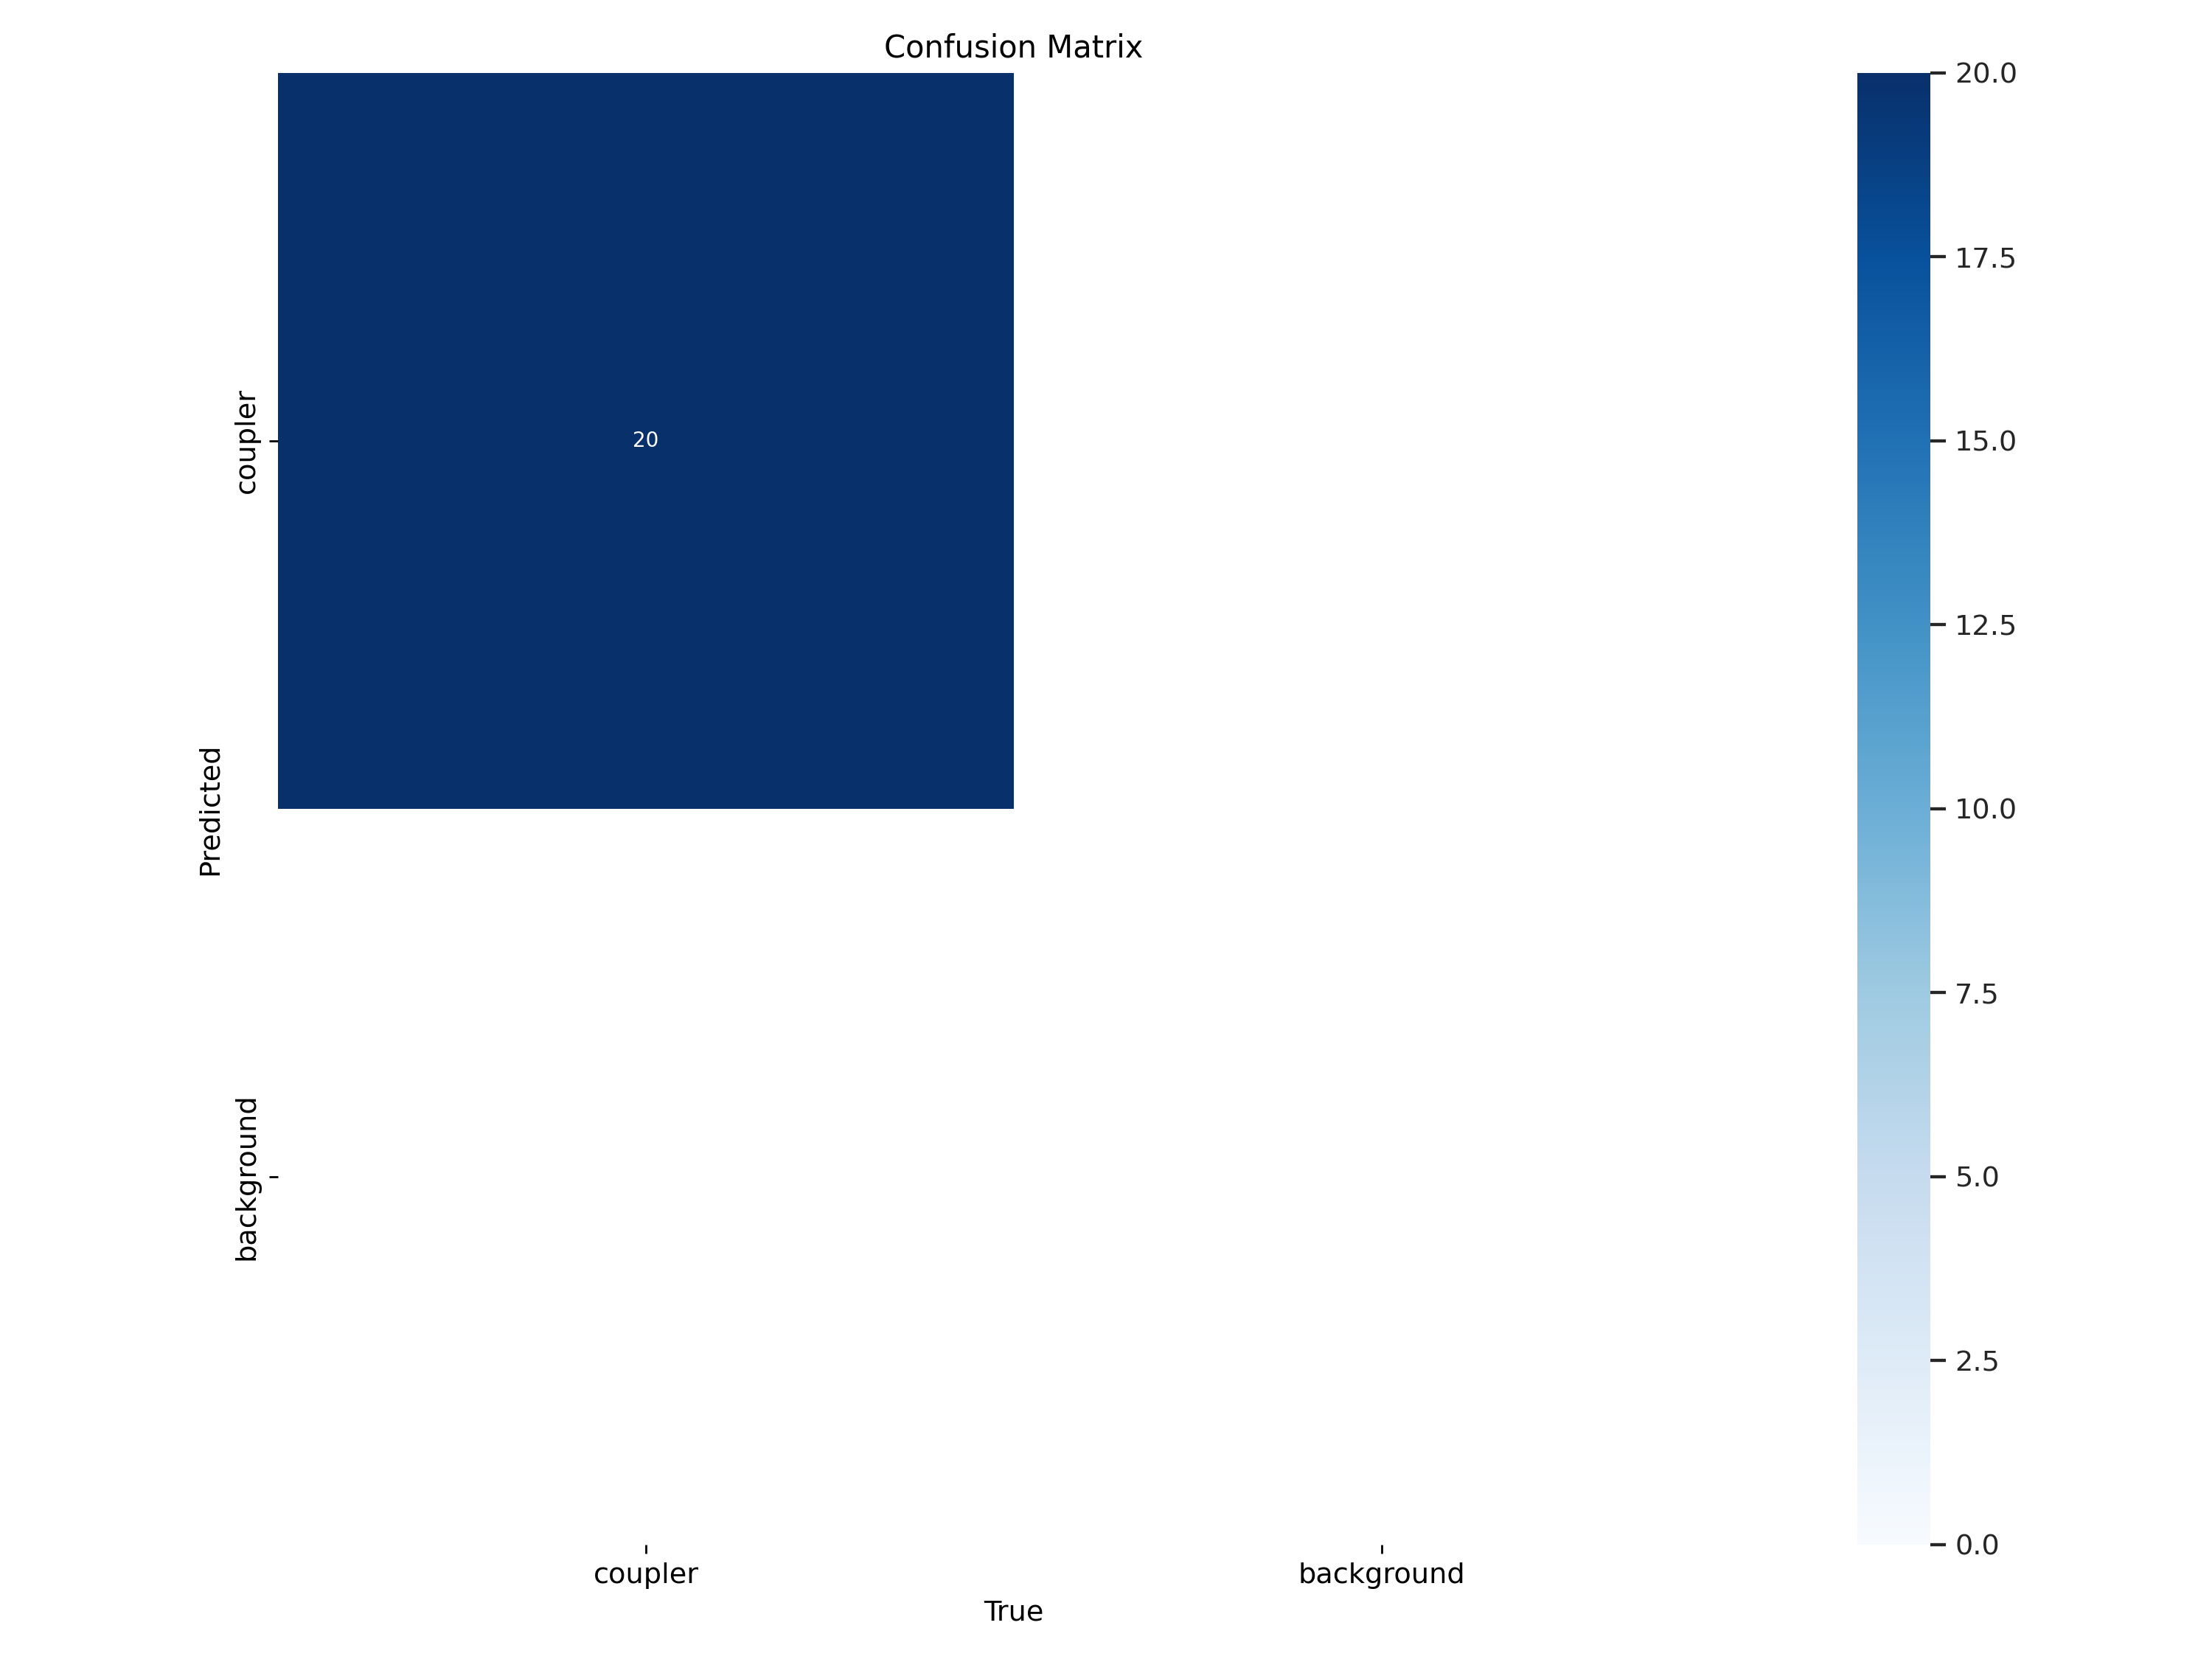

In [63]:
from IPython.display import Image

Image('/content/runs/detect/train2/confusion_matrix.png', width=640, height='480') # replace with your image path


**Training Batch**

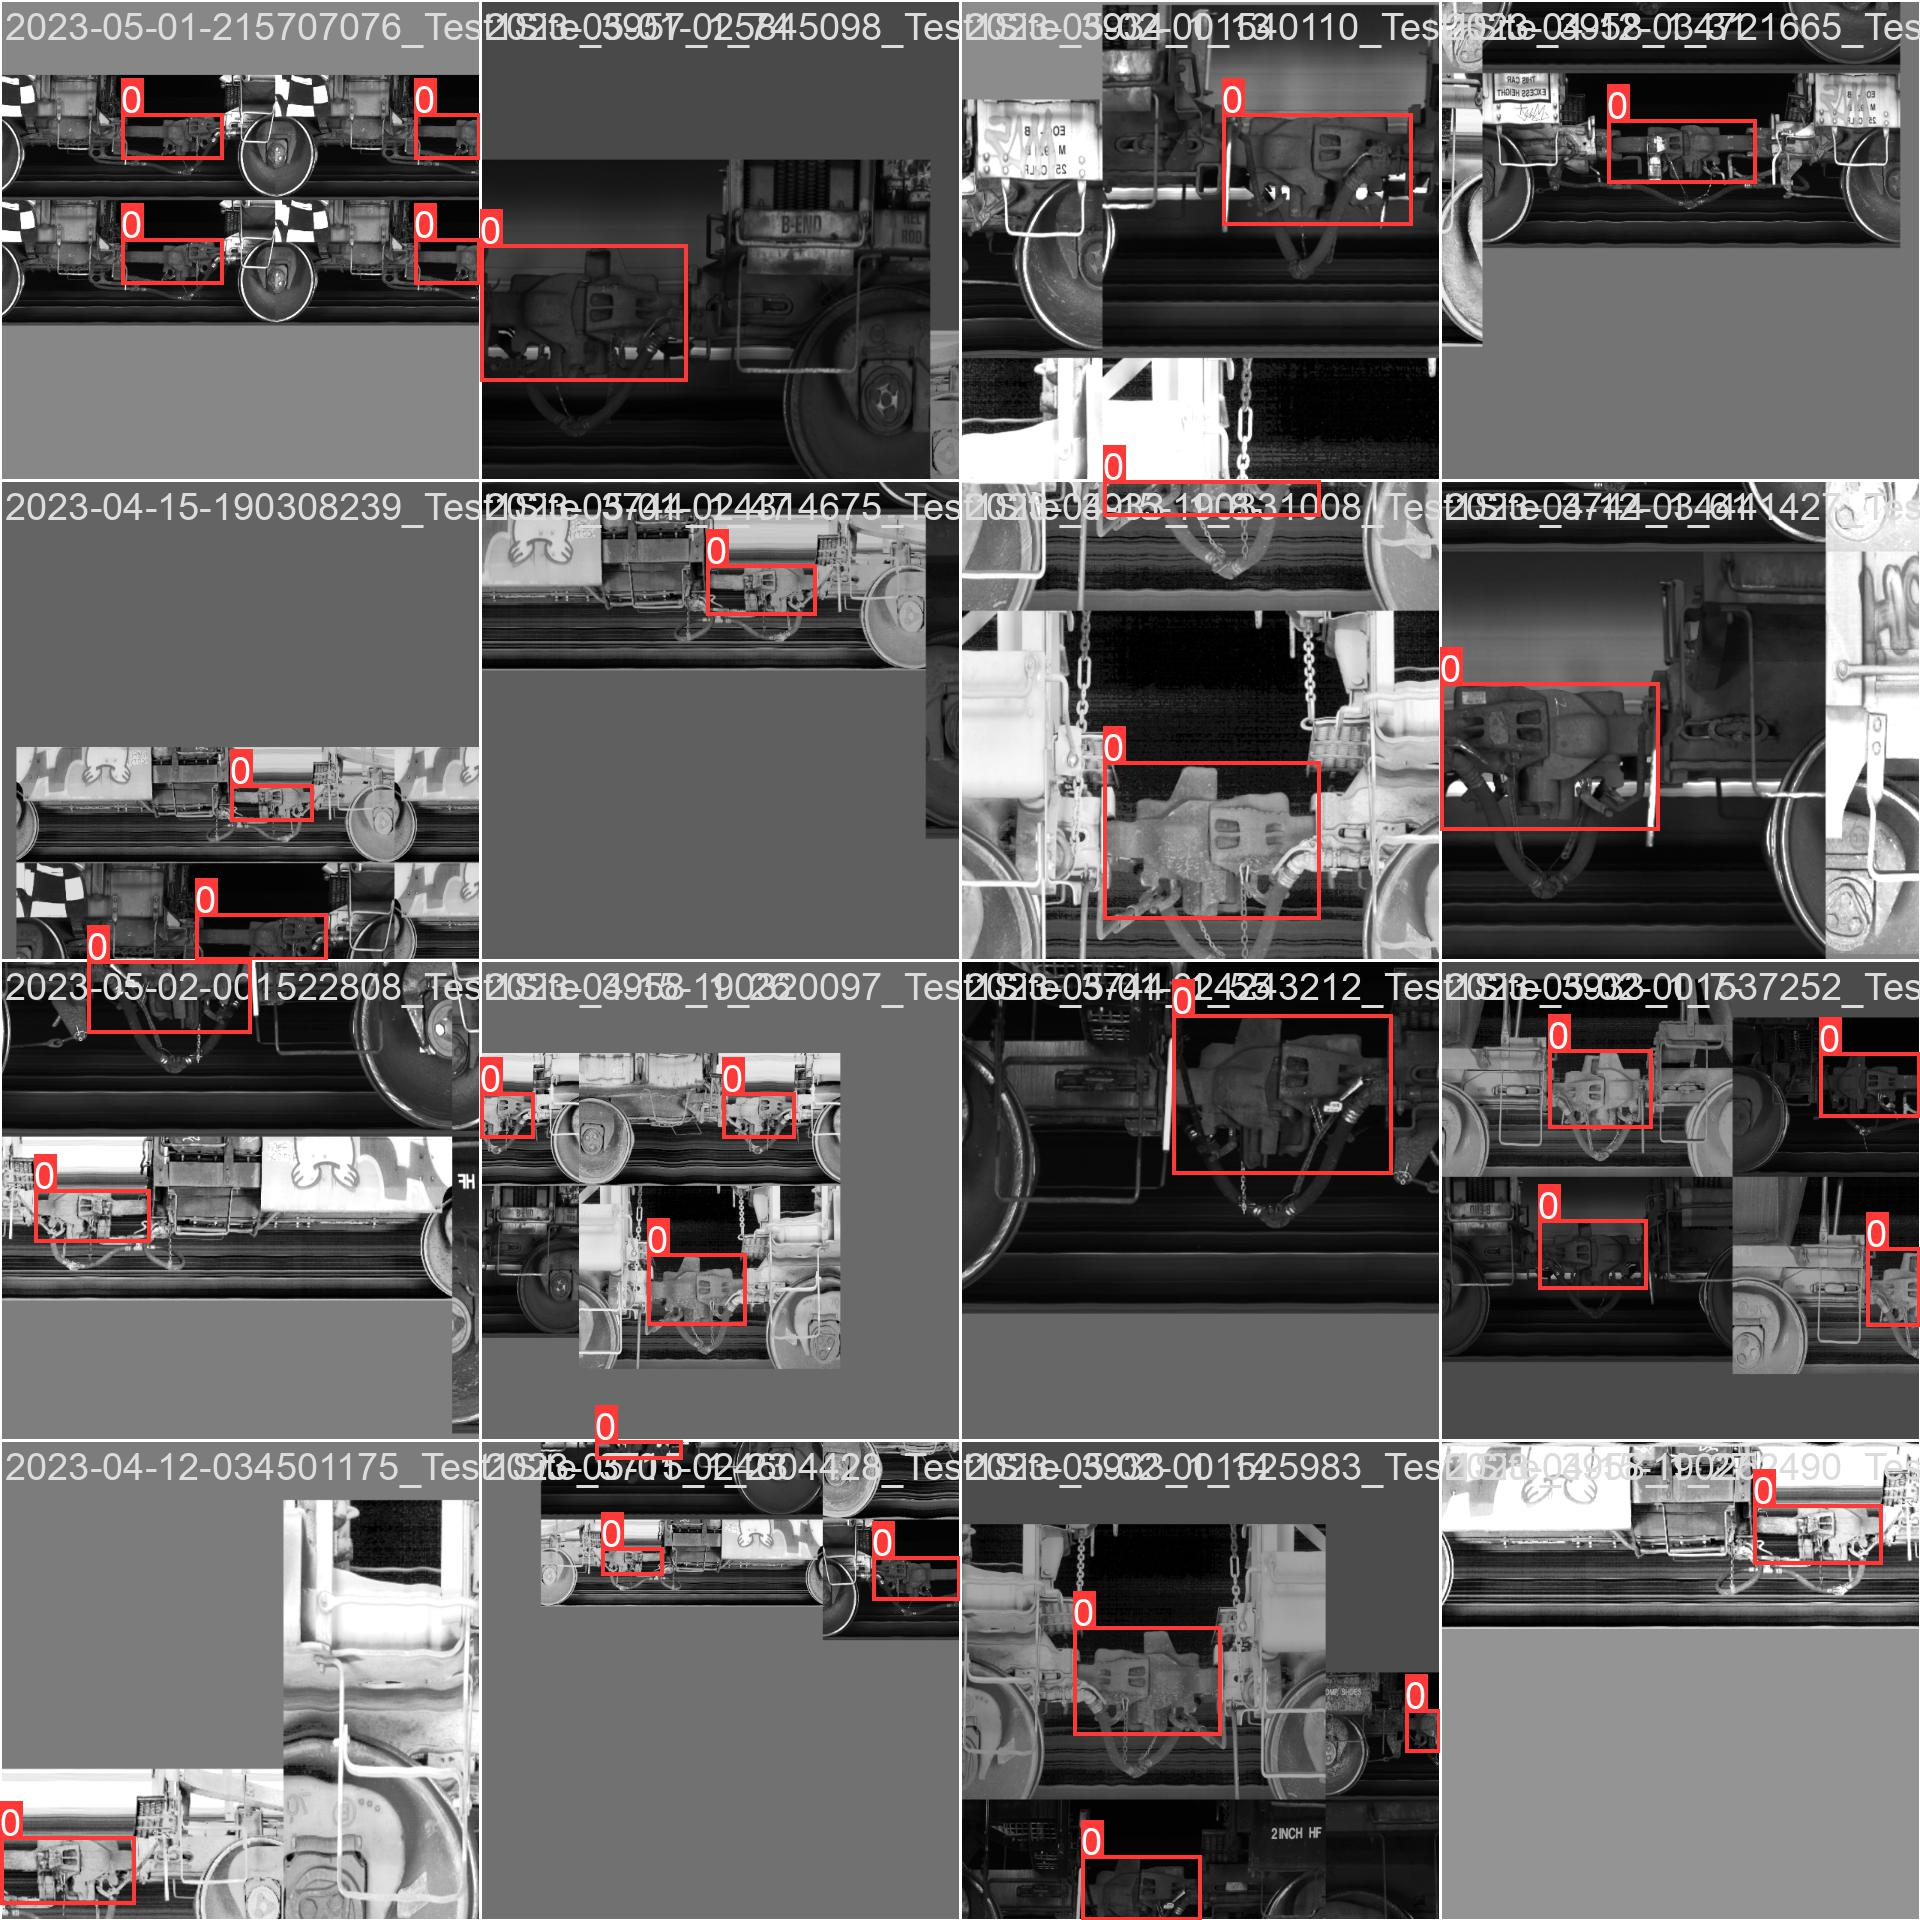

In [54]:
Image('/content/runs/detect/train2/train_batch0.jpg') # replace with your image path


**Validation Batch Labels**



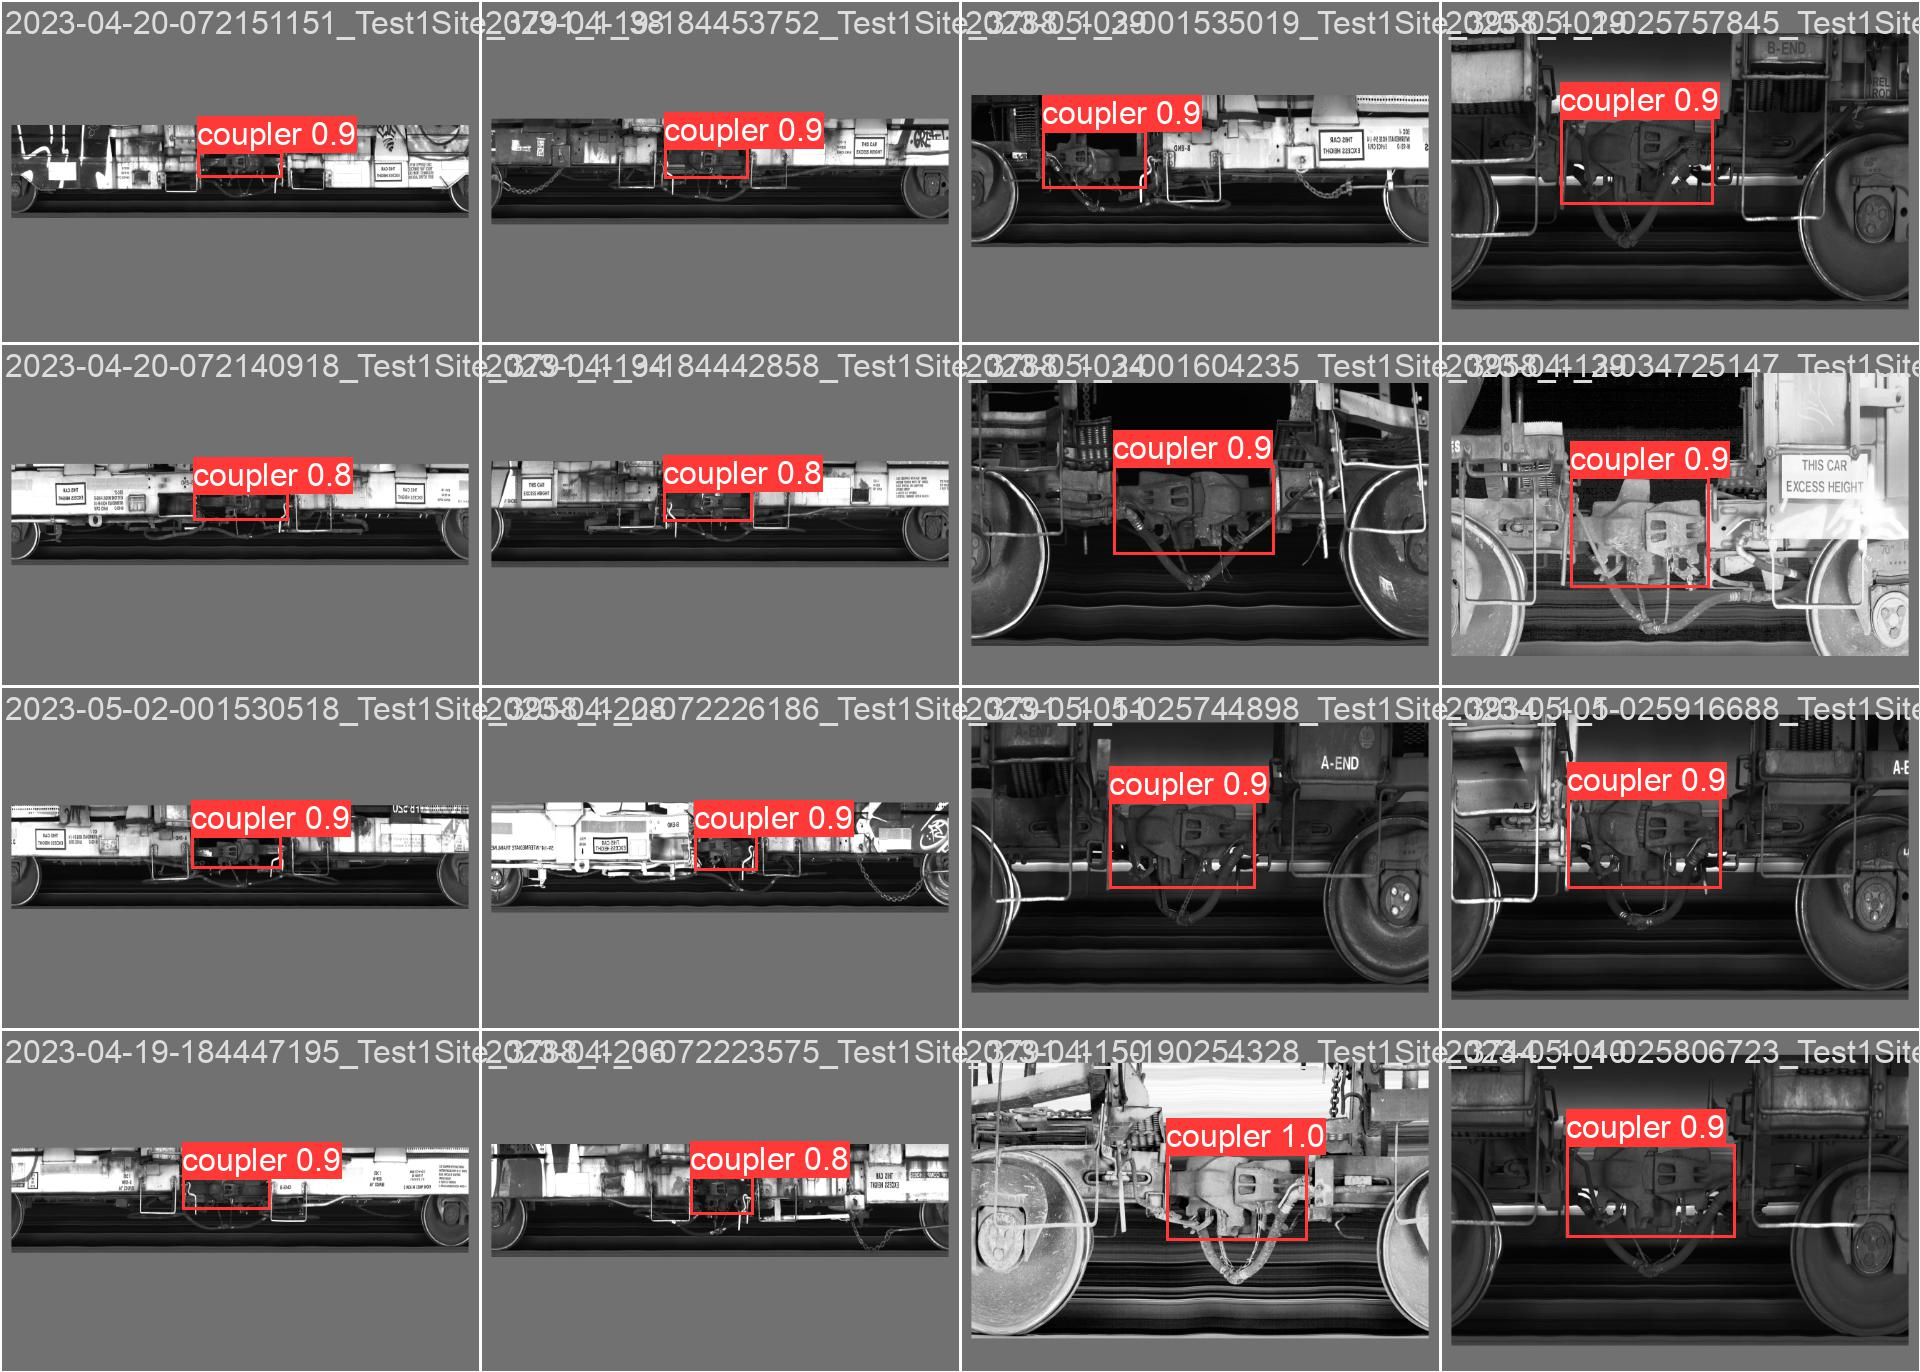

In [55]:
Image('/content/runs/detect/train2/val_batch0_pred.jpg') # replace with your image path

### Test our trained Model by running Inference

Now for the final test.  We call model.predict on the 445 images in test-images folder with a threshold of 0.50%. This means only draw bounding box rectangles for inferences with a confidence score of 50% that the classification is correct.  Drum roll please.

The results will be stored in the predict /run/predict

In [56]:
source='/content/gdrive/My Drive/Colab Notebooks/ns/data/test-images'

In [57]:
model.predict(source, save=True, conf=0.5)


image 1/459 /content/gdrive/My Drive/Colab Notebooks/ns/data/test-images/2023-05-01-184450645_Test1Site_3954_1_96-97_NS0000997515-SHQX0000011018_ls_coupler_NULL-NULL_1-A_L-R_B-B_NULL-NULL.jpeg: 416x640 1 coupler, 58.6ms
image 2/459 /content/gdrive/My Drive/Colab Notebooks/ns/data/test-images/2023-05-01-184452551_Test1Site_3954_1_97-98_SHQX0000011018-HKRX0000070059_ls_coupler_NULL-NULL_A-A_R-R_A-B_NULL-NULL.jpeg: 256x640 1 coupler, 54.9ms
image 3/459 /content/gdrive/My Drive/Colab Notebooks/ns/data/test-images/2023-05-01-184454902_Test1Site_3954_1_98-99_HKRX0000070059-HKRX0000070094_ls_coupler_NULL-NULL_A-A_R-R_A-B_NULL-NULL.jpeg: 192x640 1 coupler, 48.9ms
image 4/459 /content/gdrive/My Drive/Colab Notebooks/ns/data/test-images/2023-05-01-184523387_Test1Site_3954_1_110-111_MWCX0000102618-HKRX0000070124_ls_coupler_NULL-NULL_A-A_R-R_A-B_NULL-NULL.jpeg: 224x640 1 coupler, 52.1ms
image 5/459 /content/gdrive/My Drive/Colab Notebooks/ns/data/test-images/2023-05-01-184525677_Test1Site_3954_1_

[ultralytics.yolo.engine.results.Results object with attributes:
 
 boxes: ultralytics.yolo.engine.results.Boxes object
 keypoints: None
 keys: ['boxes']
 masks: None
 names: {0: 'coupler'}
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [157, 157, 157],
         [157, 157, 157],
         [158, 158, 158]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [158, 158, 158],
         [159, 159, 159],
         [160, 160, 160]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [160, 160, 160],
         [160, 160, 160],
         [160, 160, 160]],
 
        ...,
 
        [[ 66,  66,  66],
         [ 66,  66,  66],
         [ 67,  67,  67],
         ...,
         [ 64,  64,  64],
         [ 64,  64,  64],
         [ 64,  64,  64]],
 
        [[ 68,  68,  68],
         [ 68,  68,  68],
         [ 69,  69,  69],
         ...,
 

### Some sample predictions

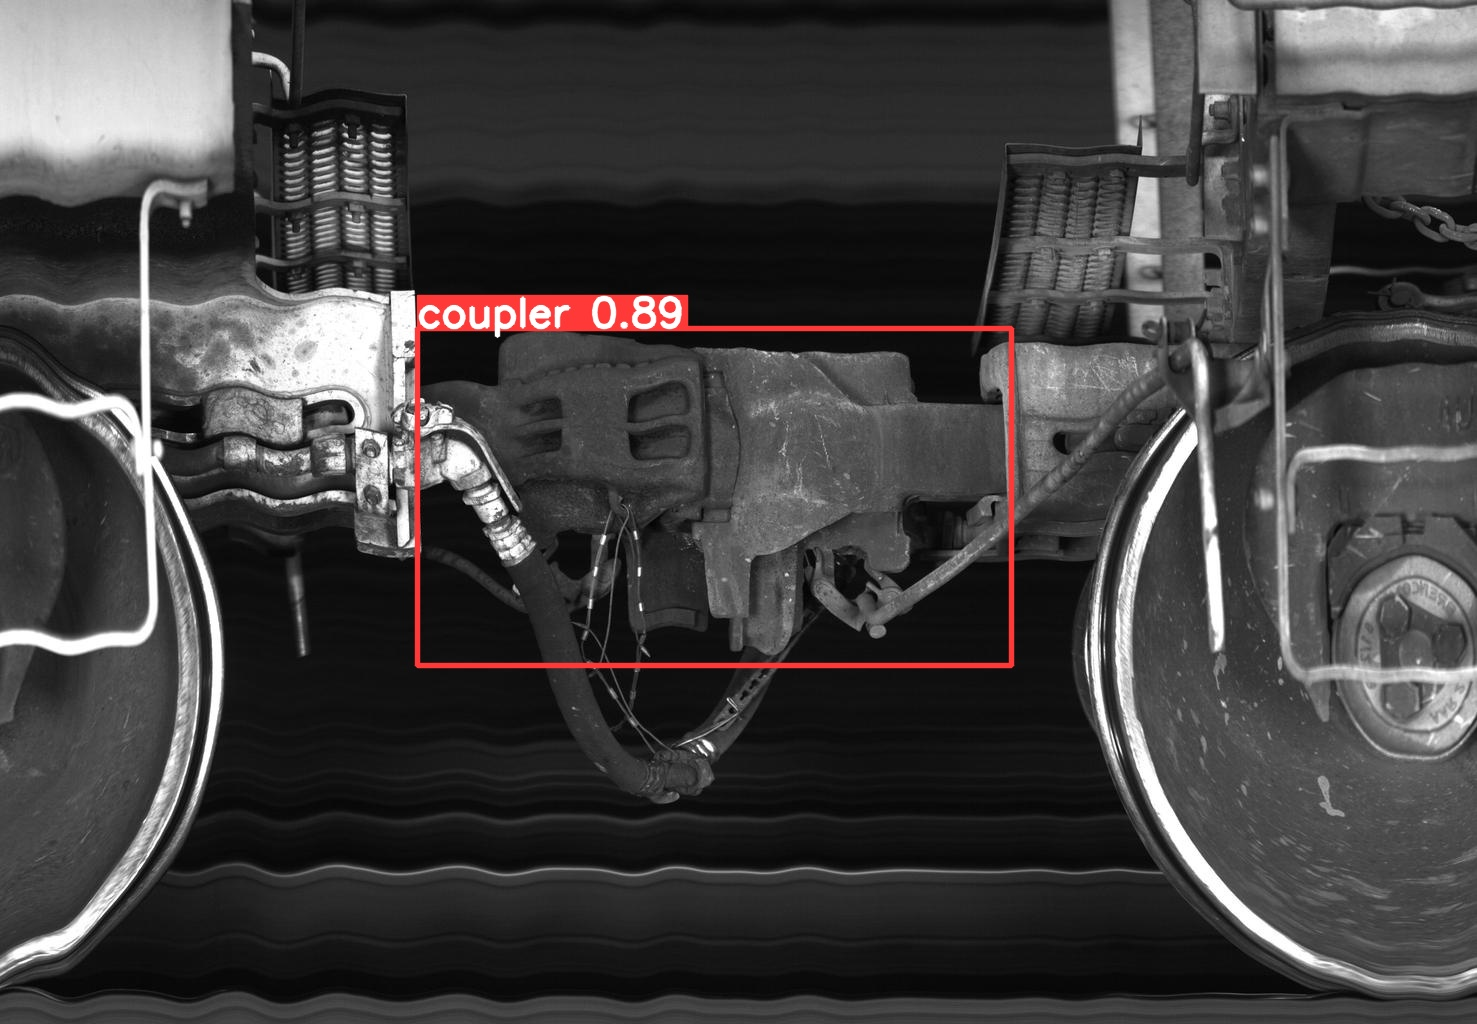

In [64]:

Image('/content/runs/detect/predict/2023-05-02-064903336_Test1Site_3959_1_83-84_RGCX0000002553-UTCX0000059632_ls_coupler_NULL-NULL_1-1_L-L_B-A_NULL-NULL.jpeg', width=640, height='480') 

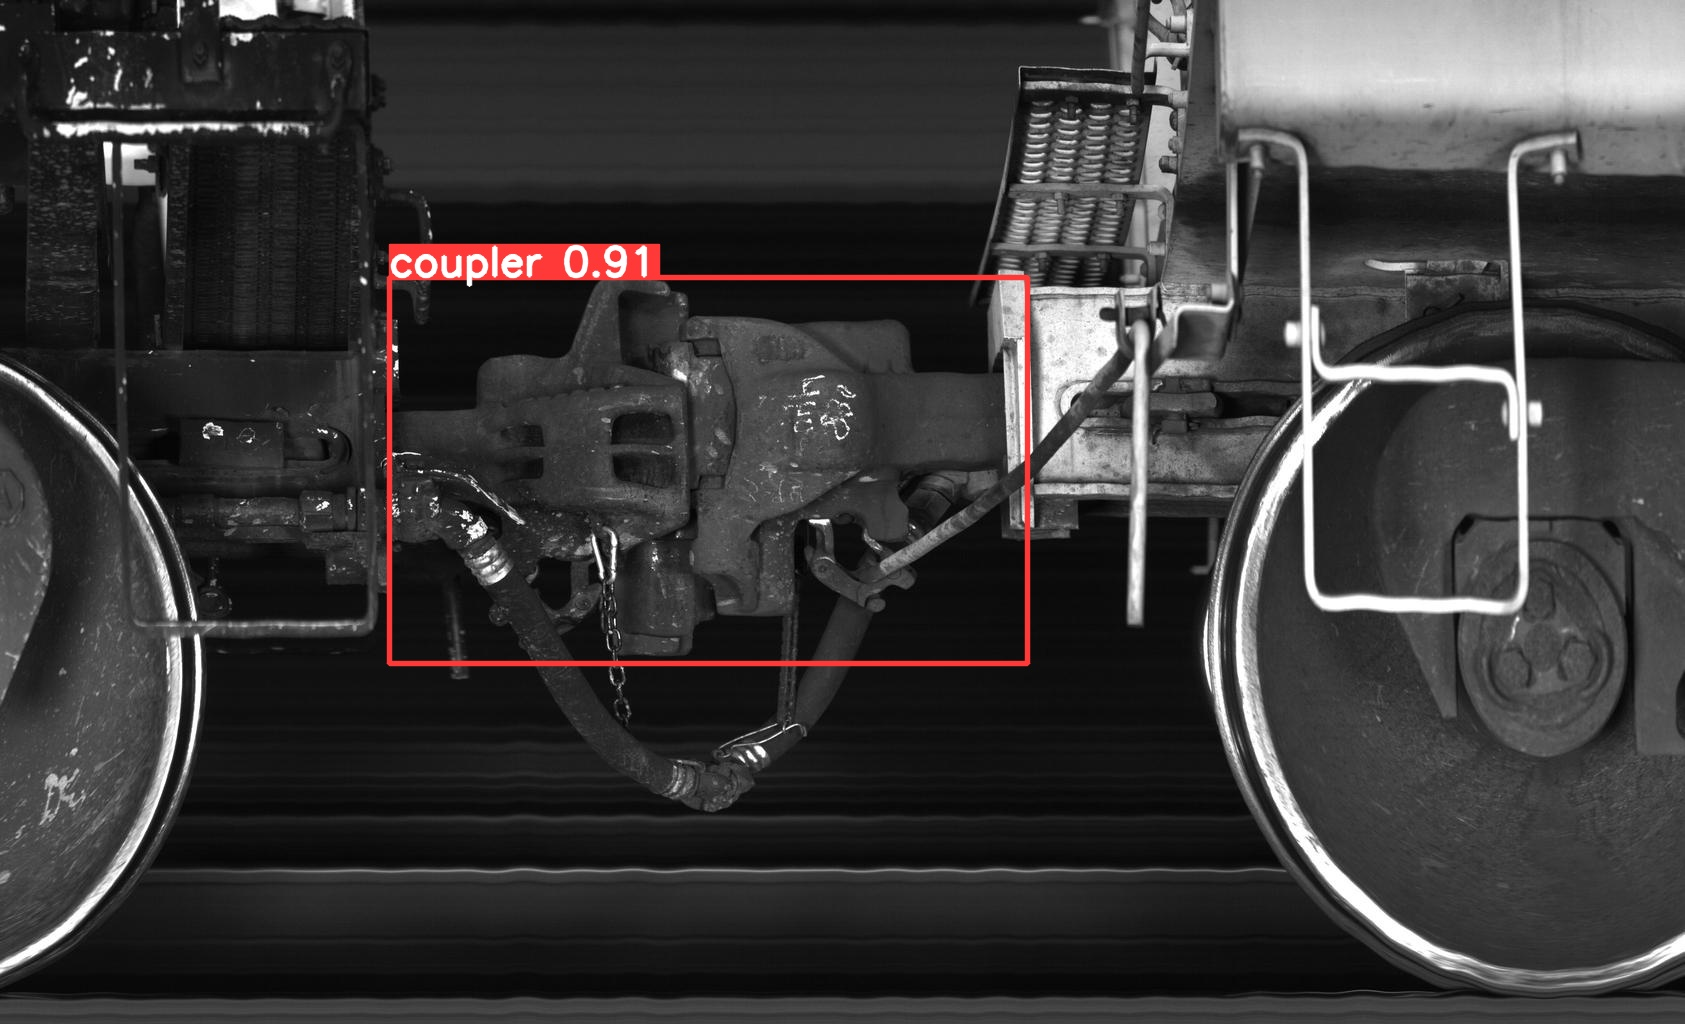

In [67]:
Image('/content/runs/detect/predict/2023-05-02-064930211_Test1Site_3959_1_86-87_UTCX0000058198-GATX0000001027_ls_coupler_B-NULL_1-A_L-R_B-B_NULL-NULL.jpeg') # replace with your image path

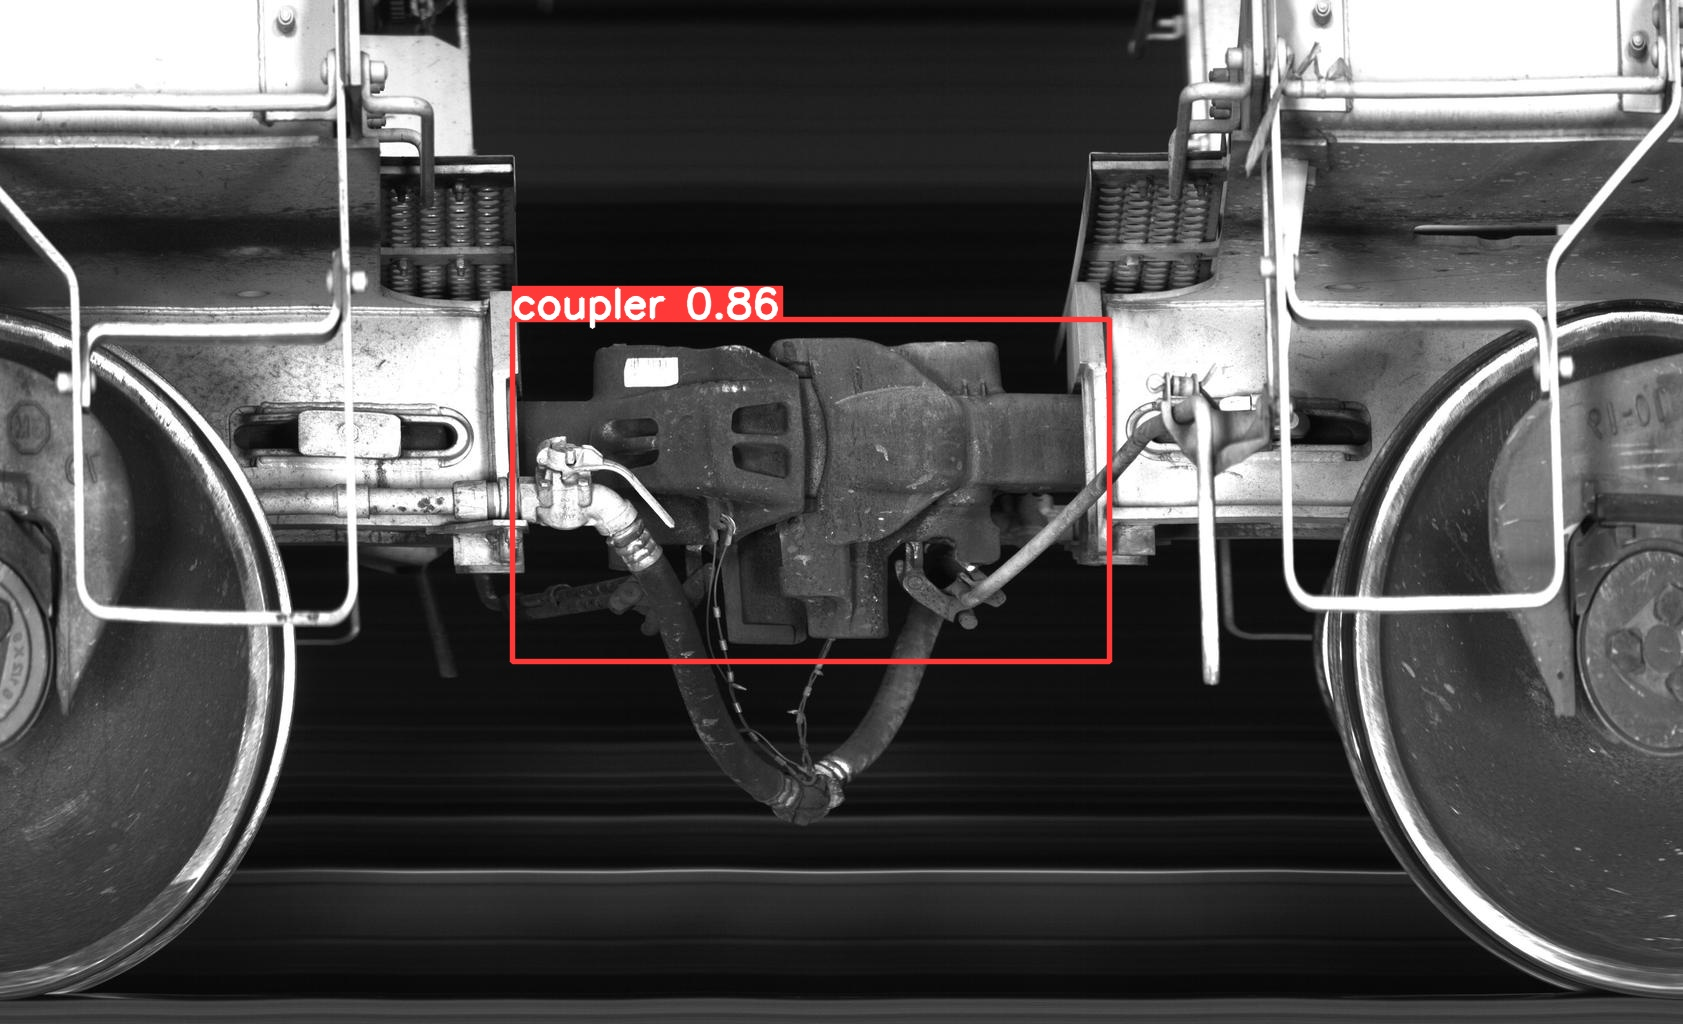


### Improve results

Given unlimited time and resources, several strategies can be applied to improve the results of your object detection model:

* **More Data**: Collect and annotate more data. This helps to improve the generalization capability of the model.

* **Data Augmentation**: Implement data augmentation techniques to increase the diversity of the training set, which can help improve the model's robustness to different conditions.

* **Hyperparameter Tuning**: I could run an extensive hyperparameter search (learning rate, batch size, number of layers in the network, etc.) to find the optimal configuration for your model.

* **Transfer Learning**: Use different yolo models that have been pre-trained on a larger datasets.

* **Different Computer Vision Models** for example since performance is not a requirment today, Faster RCNN maybe a good alternate choice



